In [1]:
from pandana.loaders import osm
import geopandas as gpd
import pydeck as pdk
import ee
import multiprocessing
from functools import partial
import pandas as pd
import contextily as ctx
from mapbox import Directions
import googlemaps
import plotly.express as px
import h3
from googlemaps import Client as GoogleMaps
from datetime import datetime
import cartopy.crs as ccrs
import seaborn as sns
import cartopy.feature as cfeature
from tobler.util import h3fy
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
import multiprocessing
from tobler.area_weighted import area_interpolate
import plotly.io as pio
import transbigdata as tbd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import requests
import dask
import datashader as ds
import datashader.transfer_functions as tf
from shapely.geometry import LineString, MultiLineString, Point
import plotly.express as px
import io
import zipfile
import warnings
import numpy as np
import matplotlib.cm as cm
import folium
from matplotlib.colors import LogNorm
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from shapely import wkt
import pandana
import contextily as cx
import matplotlib.patches as mpatches
from shapely.ops import cascaded_union
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# New York Sate (FIFP=36) county shapfile data
# url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
nyc_county_data = gpd.read_file('NYC_county/geo_export_6e32161b-8a0a-4cf4-8959-d7a0d8943a54.shp')

In [3]:
CO2_ev = pd.read_csv('CO2_ev.csv')
CO2_ev.shape

(28926, 21)

In [4]:
gdf = gpd.GeoDataFrame(CO2_ev, geometry=[Point(xy) for xy in zip(CO2_ev['origin_bgrp_lng_2020'], CO2_ev['origin_bgrp_lat_2020'])],crs="EPSG:4326")
hexes = h3fy(nyc_county_data, resolution=8, clip=True)  # edge length of approximately 0.74 km and spans an area of approximately 3 km²
hexes = hexes.reset_index()
# hexes['hex_id'] = hexes['geometry'].apply(lambda x: h3.geo_to_h3(x.centroid.y, x.centroid.x, resolution=8))
# hexes.set_index('hex_id', inplace=True)

In [5]:
# Function to convert lat, long to h3 hex id at a specified resolution
def lat_lng_to_h3(lat, lng, resolution=8):
    return h3.geo_to_h3(lat, lng, resolution)

# Apply the function to each row in the GeoDataFrame
gdf['hex_id'] = gdf.apply(lambda row: lat_lng_to_h3(row['geometry'].y, row['geometry'].x, resolution=8), axis=1)

In [6]:
# Function to convert lat, long to h3 hex id at a specified resolution (Assign Hexagon to Each Point in gdf)
def lat_lng_to_h3(lat, lng, resolution=8):
    return h3.geo_to_h3(lat, lng, resolution)
gdf['hex_id'] = gdf.apply(lambda row: lat_lng_to_h3(row['geometry'].y, row['geometry'].x, resolution=8), axis=1)

# Group by hex_id and count the number of points in each hexagon (Aggregate Points by Hexagon)
hex_point_counts = gdf.groupby('hex_id').size().reset_index(name='count')

# Ensure the hex ID is set as the index in hexes for the merge
hexes.set_index('hex_id', inplace=True)
# Join the counts back to the hexes GeoDataFrame
hexes = hexes.join(hex_point_counts.set_index('hex_id'))
# Fill NaN values with 0 where there are no points in a hexagon
hexes['count'].fillna(0, inplace=True)

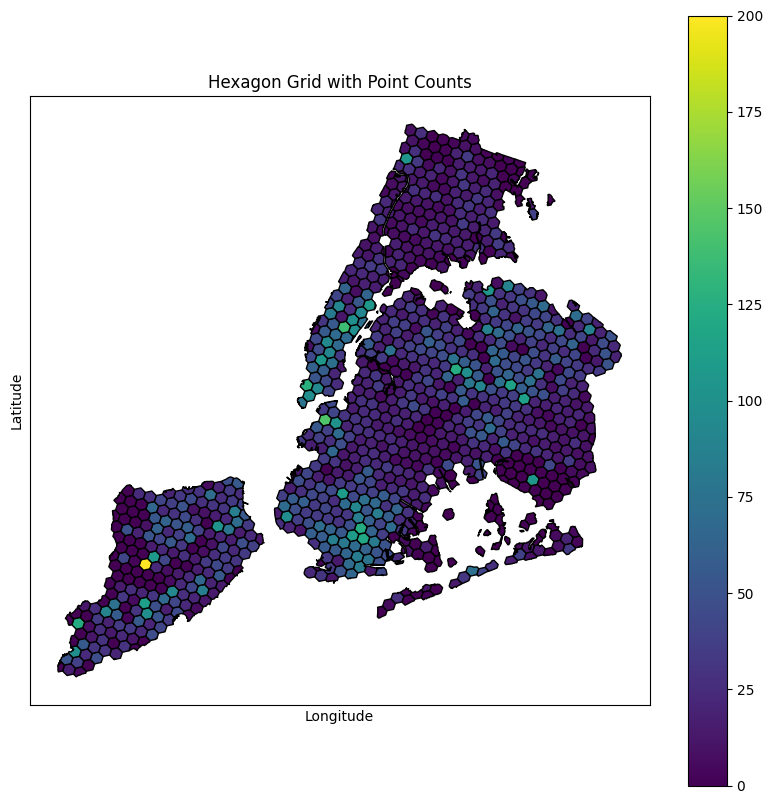

"\nplt.style.use('ggplot')  # Changes the background and gridlines to a ggplot style\nfig, ax = plt.subplots(figsize=(12, 12))  # Adjusting the size for better visibility\nhexes_plot = hexes.plot(ax=ax, column='count', cmap='coolwarm', legend=True, edgecolor='white', linewidth=0.2, alpha=0.6)\n\n# Add title and labels as needed\nax.set_title('Hexagon Grid with Point Counts', fontsize=15)\nax.set_xlabel('Longitude')\nax.set_ylabel('Latitude')\n\n# Remove x and y ticks for a cleaner map\nax.set_xticks([])\nax.set_yticks([])\n\n# Check if the legend was created and then adjust its properties\nif hexes_plot.get_legend() is not None:\n    leg = hexes_plot.get_legend()\n    leg.set_bbox_to_anchor((1, 1))\n    leg.set_title('Point Count')\n\n# Set the aspect of the map to be equal, important for spatial data\nax.set_aspect('equal')\nplt.show()\n"

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))  # You can adjust the size as needed
hexes.plot(ax=ax, column='count', cmap='viridis', legend=True, edgecolor='k')

# Add title and labels as needed
ax.set_title('Hexagon Grid with Point Counts')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Optional: Remove x and y ticks for a cleaner map
ax.set_xticks([])
ax.set_yticks([])
plt.show()

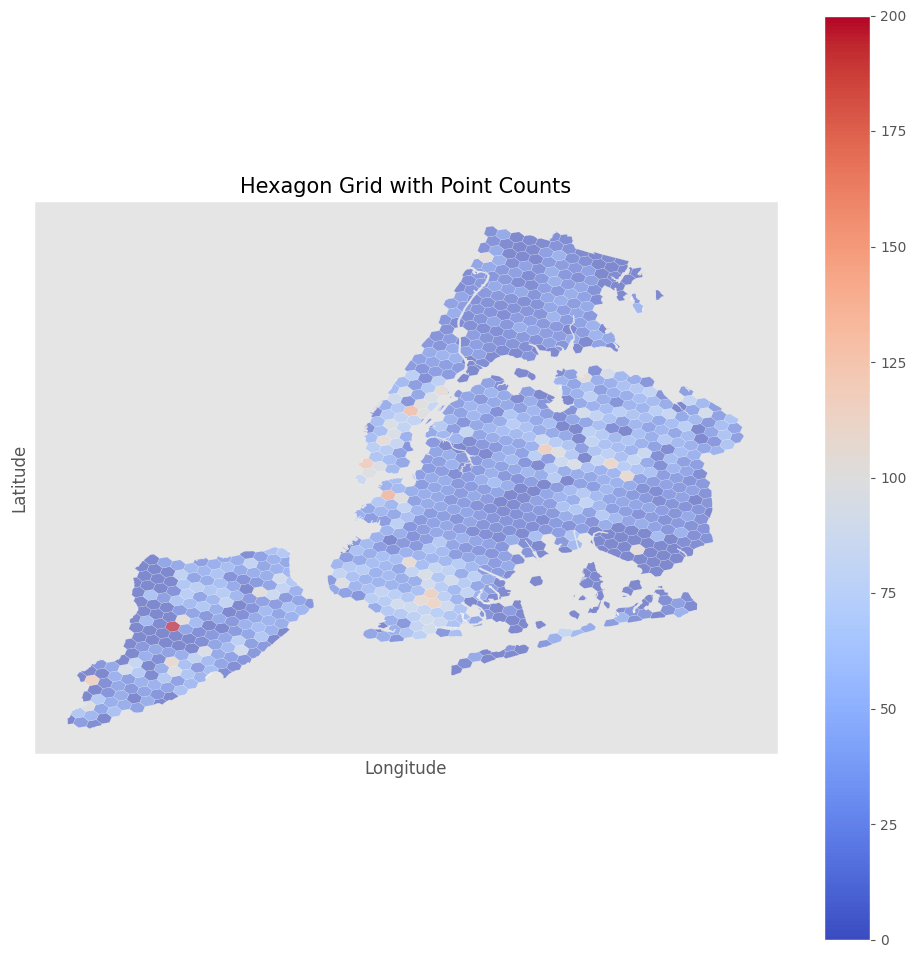

In [8]:
plt.style.use('ggplot')  # Changes the background and gridlines to a ggplot style
fig, ax = plt.subplots(figsize=(12, 12))  # Adjusting the size for better visibility
hexes_plot = hexes.plot(ax=ax, column='count', cmap='coolwarm', legend=True, edgecolor='white', linewidth=0.2, alpha=0.6)

# Add title and labels as needed
ax.set_title('Hexagon Grid with Point Counts', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove x and y ticks for a cleaner map
ax.set_xticks([])
ax.set_yticks([])

# Check if the legend was created and then adjust its properties
if hexes_plot.get_legend() is not None:
    leg = hexes_plot.get_legend()
    leg.set_bbox_to_anchor((1, 1))
    leg.set_title('Point Count')

# Set the aspect of the map to be equal, important for spatial data
ax.set_aspect('equal')
plt.show()

In [9]:
hexes = hexes.reset_index()
hexes.columns
# hexes.to_csv('NYC_EV_Demand_HEX.csv')

Index(['hex_id', 'geometry', 'count'], dtype='object')